Rezolvare de 96/100

Este simpla si scurta, fiind bazata doar pe procesare de imagini cu OpenCV, fara niciun model utilizat.

In [197]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import cv2

import os

In [198]:
seed = 42
root_path = "/home/stefan/ioai-prep/kits/roai-2025/hotspot"

# Data preparation

In [199]:
def image_to_rle(img_arr: np.array) -> list[int]:
    side, side = img_arr.shape[0], img_arr.shape[1]
    img_arr = img_arr.reshape(side*side, order='F')
    
    start = 0
    length = 0
    res = []
    for i in range(side * side):
        if img_arr[i] == 255:
            if length == 0:
                start = i + 1
            length = length + 1
        else:
            if length > 0:
                res.append(start)
                res.append(length)
            length = 0
    if length > 0:
        res.append(start)
        res.append(length)
        
    return res

In [200]:
def get_subtask_images(subtask_id: int) -> list[np.array]:
    path = f"{root_path}/Satellite_Images-{subtask_id}"
    images = os.listdir(path)
    
    arr = []
    for image_path in images:
        img = np.array(Image.open(f"{path}/{image_path}")) # .shape = (256, 256, 3)
        arr.append({"img": img, "filename": image_path})
    
    return arr

# Image processing

In [201]:
subtask4_images = get_subtask_images(4)

In [ ]:
def get_mask(img: np.array, subtask_id: int = 3) -> np.array:
    grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.medianBlur(grayscale, 7)

    threshold_value = 60 if subtask_id != 4 else 80
    _, threshold = cv2.threshold(blur, threshold_value, 255, cv2.THRESH_BINARY)
    return threshold # .shape = (256, 256)

<Figure size 640x480 with 0 Axes>

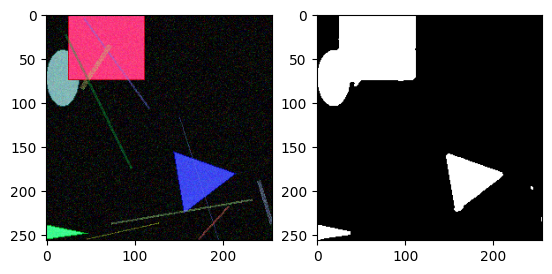

In [203]:
plt.figure()
f, axarr = plt.subplots(1, 2) 

img = subtask4_images[11]["img"]
masked = get_mask(img)

axarr[0].imshow(img)
axarr[1].imshow(masked, cmap='gray')

In [ ]:
# is the format good for RLE?
len(image_to_rle(masked)) > 0

True

# Submission

In [205]:
subtasks = [{"masked": [], "id": []} for _ in range(4)]

In [206]:
for subtask_id in range(4):
    subtask_images = get_subtask_images(subtask_id+1)

    for image in tqdm(subtask_images):
        masked = get_mask(image["img"], subtask_id+1)
        masked_rle = image_to_rle(masked)

        subtasks[subtask_id]["masked"].append(masked_rle)
        subtasks[subtask_id]["id"].append(image["filename"])

100%|██████████| 250/250 [00:02<00:00, 84.73it/s]


In [207]:
subtasks_df = [
    pd.DataFrame({
        "subtaskID": i+1,
        "datapointID": subtask["id"],
        "answer": subtask["masked"],
    }) for i, subtask in enumerate(subtasks)
]

submission = pd.concat(subtasks_df, ignore_index=True)

In [208]:
submission.head()

,subtaskID,datapointID,answer
0,1,image_00090.png,"[56747, 4, 57001, 8, 57256, 11, 57511, 14, 577..."
1,1,image_00035.png,"[26775, 67, 27029, 71, 27285, 71, 27540, 73, 2..."
2,1,image_00098.png,"[53771, 1, 54025, 5, 54280, 7, 54534, 9, 54789..."
3,1,image_00051.png,"[454, 11, 707, 17, 961, 21, 1215, 25, 1469, 29..."
4,1,image_00208.png,"[5, 43, 261, 43, 517, 43, 773, 43, 1029, 43, 1..."


In [209]:
submission.to_csv("submission.csv", index=False)